# Deep Dream

Using pretrained Inception V3 with Pytorch.

References:

- [Deep Dream TF 2.0](https://www.mlq.ai/deep-dream-with-tensorflow-2-0/)
- [Deep Dream TF Core](https://www.tensorflow.org/tutorials/generative/deepdream)

In [0]:
 import torch
import torchvision
from torchvision import transforms as T
from torch import nn
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Deep Dream Model

Our Deep Dream model will load the pretrained Inception V3 and register hooks to save the outputs of the given **layers of interest**. We will call this partial outputs as **features**.

This outputs will be saved into an array to used later to compute the target loss.

In [2]:
dict(torchvision.models.inception_v3(pretrained=True).named_children()).keys()

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth


dict_keys(['Conv2d_1a_3x3', 'Conv2d_2a_3x3', 'Conv2d_2b_3x3', 'Conv2d_3b_1x1', 'Conv2d_4a_3x3', 'Mixed_5b', 'Mixed_5c', 'Mixed_5d', 'Mixed_6a', 'Mixed_6b', 'Mixed_6c', 'Mixed_6d', 'Mixed_6e', 'AuxLogits', 'Mixed_7a', 'Mixed_7b', 'Mixed_7c', 'fc'])

In [0]:
%%capture

class DeepDream(nn.Module):
    """
    Deep Dream Model:
    Params:
        - loi: layers of interest: names of the layers
               that will be saved with hooks to perform the
               deep dream loss.
    """

    def __init__(self, loi):
        super(DeepDream, self).__init__()

        # load pretrained model
        self.layers = torchvision.models.inception_v3(pretrained=True)

        # prepare hooks
        self.features = []
        self.hooks = []
        for layer in loi:
            s_layer = dict(self.layers.named_children())[layer]
            self.hooks.append(s_layer.register_forward_hook(self.feature_hook))
    
    def feature_hook(self, module, _in, _out):
        self.features.append(_out)
    
    def remove(self):
        [hook.remove() for hook in self.hooks]

    def forward(self, x):
        self.features = []
        return self.layers(x)

## Image Utils

In [0]:
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
IMEAN=[-0.485/0.229, -0.456/0.224, -0.406/0.225]
ISTD=[1/0.229, 1/0.224, 1/0.225]
SOURCE_IMAGE = 'bunny.jpg'
SIZE = Image.open(SOURCE_IMAGE).size[::-1]

preprocess = T.Compose([
    T.Resize(224),
    T.ToTensor(),
    T.Normalize(mean=MEAN, std=STD)
])

postprocess = T.Compose([
    T.Normalize(IMEAN, ISTD),
    T.ToPILImage(),
    T.Resize(SIZE)
])

def clip(image):
    for c in range(3):
        m, s = MEAN[c], STD[c]
        image[0, c] = torch.clamp(image[0, c], -m / s, (1 - m) / s)
    return image

## Loss function

In [0]:
def deep_dream_loss(model, target):
    # run the image through the net
    _ = deep_dream(target)

    # get the loss
    losses = [torch.mean(act) for act in model.features]
    loss = torch.stack(losses, axis=0).sum()
    return loss

## Run

We will pass several times the input through our model and modify the **target** using the loss. We will use Gradient Ascend as we need to maximize this *pseudo loss*.

In [6]:
EPOCHS = 1000
LEARNING_RATE = 0.01
LOI = ['Mixed_6a', 'Mixed_7a']

deep_dream = DeepDream(loi=LOI).to(device).eval()

bunny = Image.open(SOURCE_IMAGE)
target = preprocess(bunny).unsqueeze(0).to(device).requires_grad_(True)


loop = tqdm(range(EPOCHS))
for e in loop:
    # update tqdm
    loop.set_description(f'Epoch {e}/{EPOCHS}')

    # reset gradient
    if target.grad is not None:
        target.grad.zero_()

    # loss backward
    loss = deep_dream_loss(deep_dream, target)
    loss.backward(retain_graph=True)
    loop.set_postfix(loss=loss.item())

    # gradient ascent step
    gradients = target.grad.data / (torch.std(target.grad.data) + 1e-8)
    target.data = target.data + gradients * LEARNING_RATE

    # clip pixel values
    target.data = clip(target.data)

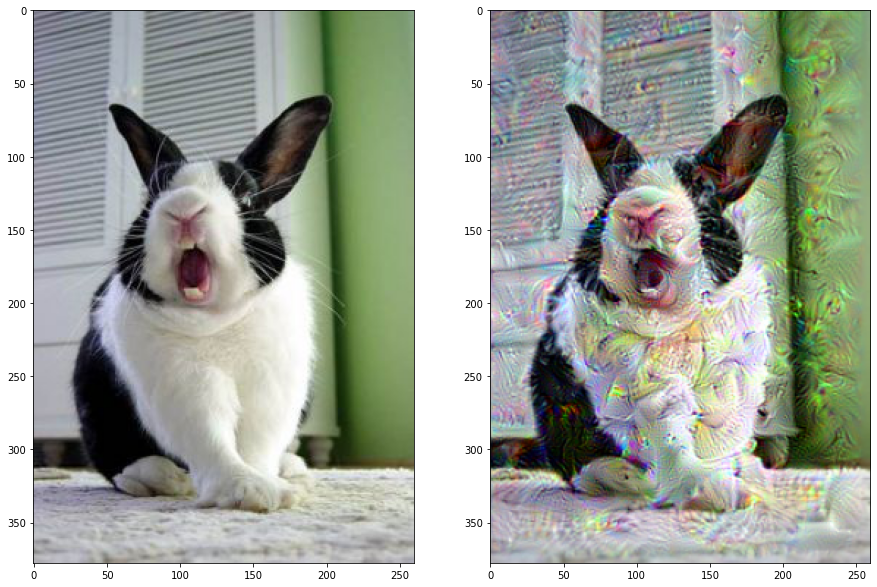

In [7]:
# show results
result = target.cpu().clone().detach().squeeze(0)
result = postprocess(result)

_, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(bunny)
ax[1].imshow(result)
plt.show()